# **TSLA Stock Moving Average Cross Strategy**

In [1]:
!pip install ta

In [2]:
import warnings
warnings.filterwarnings("ignore")

import ta
import scipy
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
from math import sqrt
import scipy.stats as ss
import statsmodels as smt
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [7]:
start_date = datetime(2016,1,1)
end_date = datetime(2023,8,25)

TSLA = yf.download('TSLA', start_date , end_date)
TSLA.reset_index(inplace = True)

[*********************100%%**********************]  1 of 1 completed


In [8]:
TSLA

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-04,15.381333,15.425333,14.600000,14.894000,14.894000,102406500
1,2016-01-05,15.090667,15.126000,14.666667,14.895333,14.895333,47802000
2,2016-01-06,14.666667,14.670000,14.398667,14.602667,14.602667,56686500
3,2016-01-07,14.279333,14.562667,14.244667,14.376667,14.376667,53314500
4,2016-01-08,14.524000,14.696000,14.051333,14.066667,14.066667,54421500
...,...,...,...,...,...,...,...
1919,2023-08-18,214.119995,217.580002,212.360001,215.490005,215.490005,135813700
1920,2023-08-21,221.550003,232.130005,220.580002,231.279999,231.279999,135702700
1921,2023-08-22,240.250000,240.820007,229.550003,233.190002,233.190002,130597900
1922,2023-08-23,229.339996,238.979996,229.289993,236.860001,236.860001,101077600


In [9]:
# Calculate additional features
TSLA["SMA_20"] = ta.trend.sma_indicator(TSLA["Close"], window = 20, fillna = True)
TSLA["SMA_50"] = ta.trend.sma_indicator(TSLA["Close"], window = 50, fillna = True)
TSLA["SMA_10"] = ta.trend.sma_indicator(TSLA["Close"], window = 10, fillna = True)
TSLA["SMA_30"] = ta.trend.sma_indicator(TSLA["Close"], window = 30, fillna = True)

TSLA["EMA_12"] = ta.trend.ema_indicator(TSLA["Close"], window = 12, fillna = True)
TSLA["EMA_26"] = ta.trend.ema_indicator(TSLA["Close"], window = 26, fillna = True)
TSLA["EMA_40"] = ta.trend.ema_indicator(TSLA["Close"], window = 40, fillna = True)
TSLA["EMA_60"] = ta.trend.ema_indicator(TSLA["Close"], window = 60, fillna = True)

TSLA["MACD"] = ta.trend.macd(TSLA["Close"], fillna = True)
TSLA["RSI"] = ta.momentum.rsi(TSLA["Close"], fillna = True)

In [10]:
TSLA

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_20,SMA_50,SMA_10,SMA_30,EMA_12,EMA_26,EMA_40,EMA_60,MACD,RSI
0,2016-01-04,15.381333,15.425333,14.600000,14.894000,14.894000,102406500,14.894000,14.894000,14.894000,14.894000,14.894000,14.894000,14.894000,14.894000,0.000000,100.000000
1,2016-01-05,15.090667,15.126000,14.666667,14.895333,14.895333,47802000,14.894667,14.894667,14.894667,14.894667,14.894205,14.894099,14.894065,14.894044,0.000106,100.000000
2,2016-01-06,14.666667,14.670000,14.398667,14.602667,14.602667,56686500,14.797333,14.797333,14.797333,14.797333,14.849353,14.872511,14.879851,14.884490,-0.023158,0.421227
3,2016-01-07,14.279333,14.562667,14.244667,14.376667,14.376667,53314500,14.692167,14.692167,14.692167,14.692167,14.776632,14.835782,14.855305,14.867840,-0.059150,0.230417
4,2016-01-08,14.524000,14.696000,14.051333,14.066667,14.066667,54421500,14.567067,14.567067,14.567067,14.567067,14.667407,14.778811,14.816835,14.841572,-0.111404,0.138045
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1919,2023-08-18,214.119995,217.580002,212.360001,215.490005,215.490005,135813700,249.049501,258.915000,236.436000,258.318667,236.874336,246.937124,247.157728,241.818482,-10.062788,27.398660
1920,2023-08-21,221.550003,232.130005,220.580002,231.279999,231.279999,135702700,247.160501,258.843400,234.419000,257.041000,236.013669,245.777337,246.383204,241.472958,-9.763668,40.743054
1921,2023-08-22,240.250000,240.820007,229.550003,233.190002,233.190002,130597900,245.556001,258.619200,232.768001,255.821000,235.579258,244.844942,245.739634,241.201386,-9.265683,42.128706
1922,2023-08-23,229.339996,238.979996,229.289993,236.860001,236.860001,101077600,244.181501,258.359800,232.235001,254.650001,235.776296,244.253465,245.306481,241.059045,-8.477169,44.799700


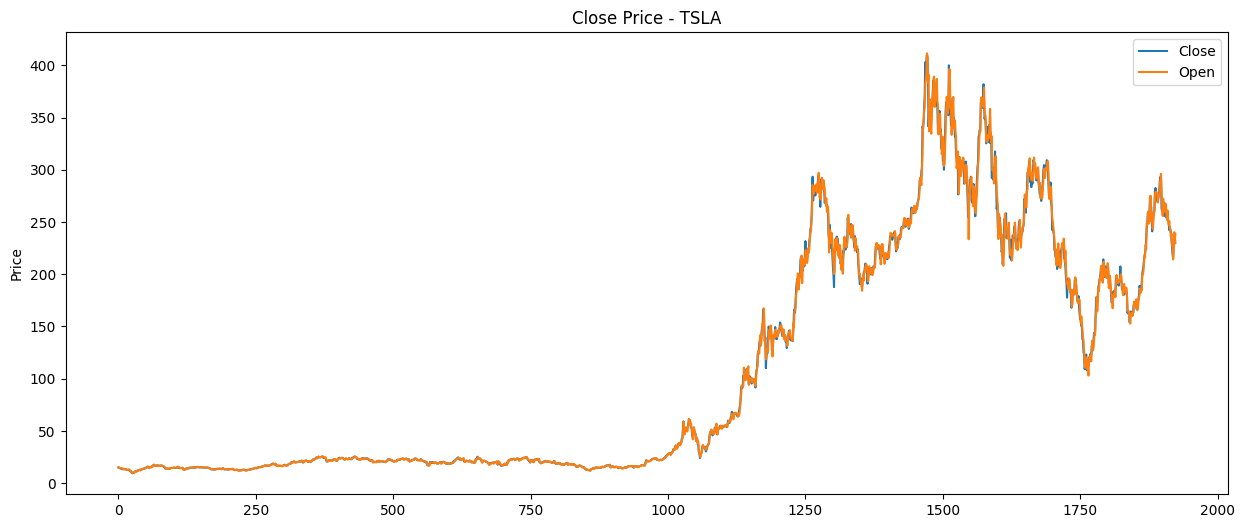

In [13]:
TSLA[['Close', 'Open']].plot(figsize=(15,6))
plt.title('Close Price - TSLA')
plt.ylabel('Price')
plt.show()

import plotly.express as px
fig = px.line(TSLA, x='Date', y=['Close', 'Open'])
fig.show()

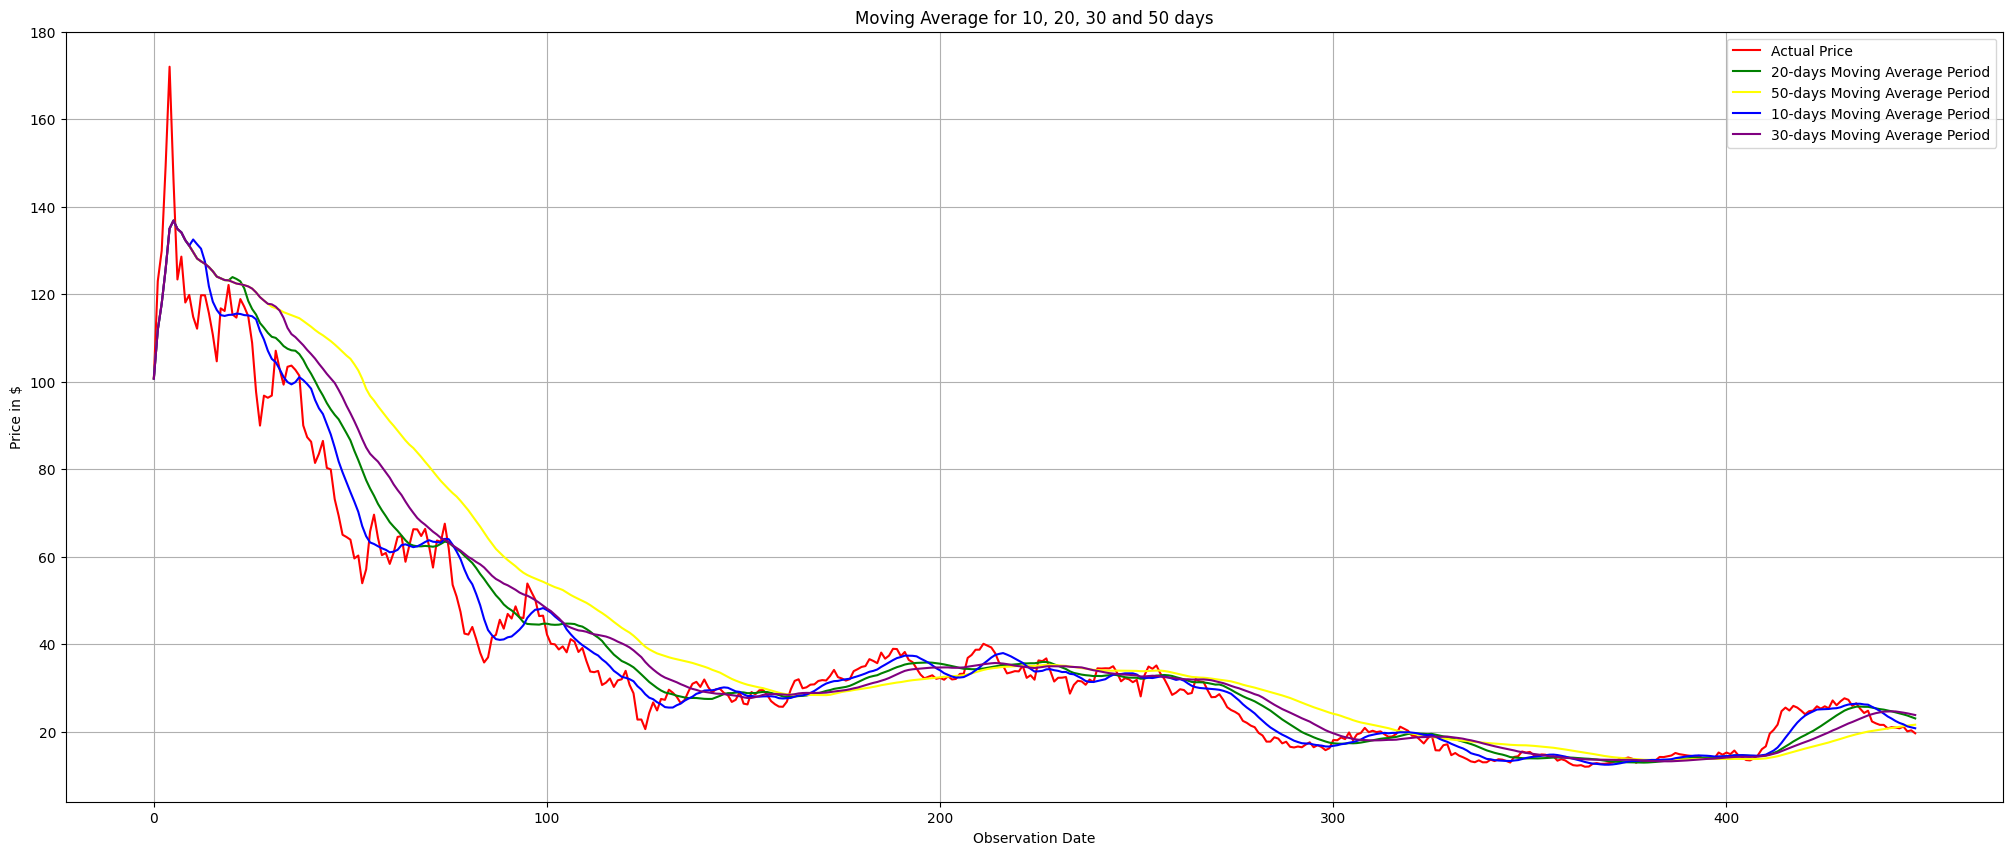

In [31]:
fig = plt.figure(figsize = (25,10))

# plot close price, short-term and long-term moving averages
TSLA['Close'].plot(label='Actual Price', color = 'red')
TSLA['SMA_20'].plot(label = '20-days Moving Average Period', color = 'green')
TSLA['SMA_50'].plot(label = '50-days Moving Average Period', color = 'yellow')
TSLA['SMA_10'].plot(label = '10-days Moving Average Period', color = 'blue')
TSLA['SMA_30'].plot(label = '30-days Moving Average Period', color = 'purple')

plt.ylabel('Price in $')
plt.xlabel('Observation Date')
plt.title('Moving Average for 10, 20, 30 and 50 days')
plt.legend()
plt.grid()
plt.show()

fig.savefig('SMA_Plot.png')

done

In [14]:
import plotly.express as px
fig = px.line(TSLA, x='Date', y=['Close','SMA_20', 'SMA_50', 'SMA_10', 'SMA_30'])
fig.show()

In [15]:
'''fig = plt.figure(figsize = (25,10))

# plot close price, short-term and long-term moving averages
TSLA['Close'].plot(label='Actual Price', color = 'red')
TSLA['EMA_12'].plot(label = '12-days EMA Span', color = 'green')
TSLA['EMA_26'].plot(label = '26-days EMA Span', color = 'yellow')
TSLA['EMA_40'].plot(label = '40-days EMA Span', color = 'blue')
TSLA['EMA_60'].plot(label = '60-days EMA Span', color = 'purple')

plt.ylabel('Price in $')
plt.xlabel('Observation Date')
plt.title('EMA Span for 12, 26, 40 and 60 days')
plt.legend()
plt.grid()
plt.show()

fig.savefig('EMA_Plot.png')
'''
import plotly.express as px
fig = px.line(TSLA, x='Date', y=['Close','EMA_12', 'EMA_26', 'EMA_40', 'EMA_60'])
fig.show()

In [33]:
TSLA['SMA_Signal'] = 0.0
TSLA['SMA_Signal'] = np.where(TSLA['SMA_20'] > TSLA['SMA_50'], 1.0, 0.0)

TSLA['SMA_Position'] = TSLA['SMA_Signal'].diff()
# display first few rows
TSLA.head()

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_20,SMA_50,SMA_10,SMA_30,EMA_12,EMA_26,EMA_40,EMA_60,MACD,RSI,SMA_Signal,SMA_Position
0,2021-11-10,106.750000,119.459999,95.199997,100.730003,100.730003,103679500,100.730003,100.730003,100.730003,100.730003,100.730003,100.730003,100.730003,100.730003,0.000000,100.0,0.0,NaN
1,2021-11-11,114.625000,125.000000,108.010002,122.989998,122.989998,83668200,111.860001,111.860001,111.860001,111.860001,104.154618,102.378892,101.815857,101.459839,1.775726,100.0,0.0,0.0
2,2021-11-12,128.645004,135.199997,125.250000,129.949997,129.949997,50636800,117.889999,117.889999,117.889999,117.889999,108.123138,104.421196,103.188254,102.393943,3.701942,100.0,0.0,0.0
3,2021-11-15,130.800003,152.529999,127.510002,149.360001,149.360001,64982300,125.757500,125.757500,125.757500,125.757500,114.467270,107.749996,105.440534,103.933814,6.717274,100.0,0.0,0.0
4,2021-11-16,163.800003,179.470001,153.779999,172.009995,172.009995,94036600,135.007999,135.007999,135.007999,135.007999,123.319997,112.509996,108.687825,106.165819,10.810001,100.0,0.0,0.0


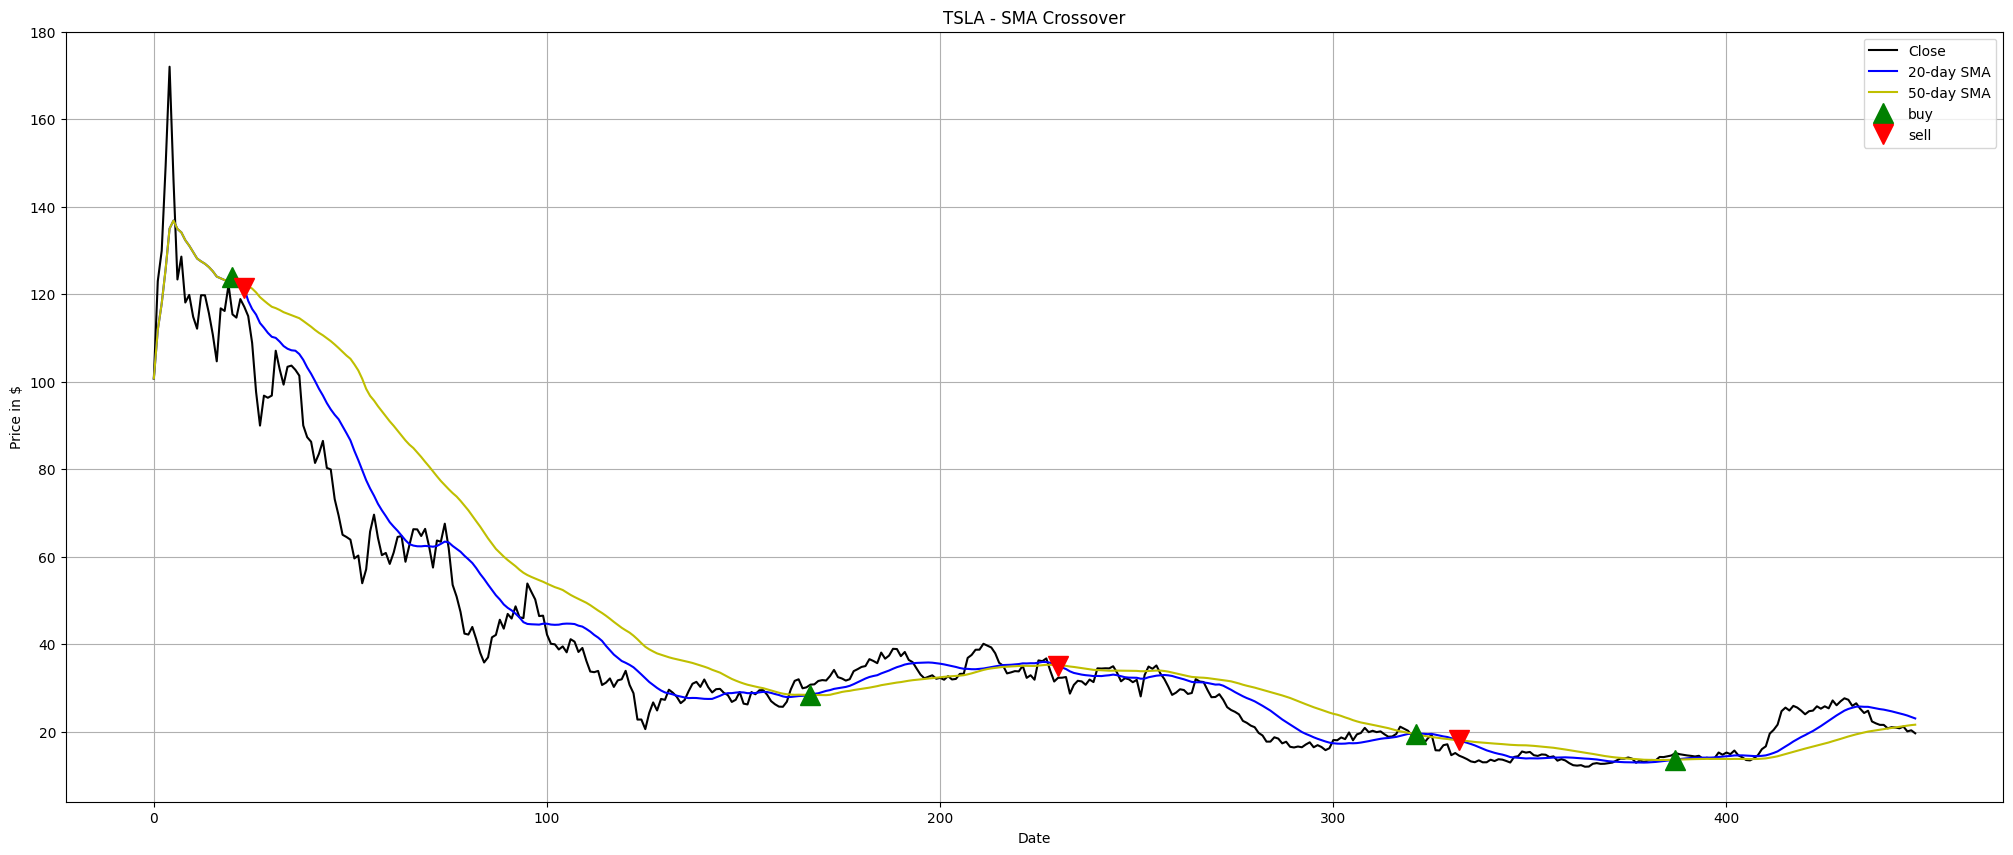

In [34]:
fig = plt.figure(figsize = (25,10))

# plot close price, short-term and long-term moving averages
TSLA['Close'].plot(color = 'k', label= 'Close')
TSLA['SMA_20'].plot(color = 'b',label = '20-day SMA')
TSLA['SMA_50'].plot(color = 'y',label = '50-day SMA')

# plot ‘buy’ signals
plt.plot(TSLA[TSLA['SMA_Position'] == 1].index,
         TSLA['SMA_20'][TSLA['SMA_Position'] == 1],
         '^', markersize = 15, color = 'g', label = 'buy')

# plot ‘sell’ signals
plt.plot(TSLA[TSLA['SMA_Position'] == -1].index,
         TSLA['SMA_20'][TSLA['SMA_Position'] == -1],
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Price in $')
plt.xlabel('Date')
plt.title('TSLA - SMA Crossover')
plt.legend()
plt.grid()
plt.show()

fig.savefig('SMA_Crossover_Plot.png')

In [35]:
# Create a new column 'Signal' such that if 12-day EMA is greater than 26-day EMA then set Signal as 1 else 0
TSLA['EMA_Signal'] = 0.0
TSLA['EMA_Signal'] = np.where(TSLA['EMA_12'] > TSLA['EMA_26'], 1.0, 0.0)
TSLA['EMA_Position'] = TSLA['EMA_Signal'].diff()

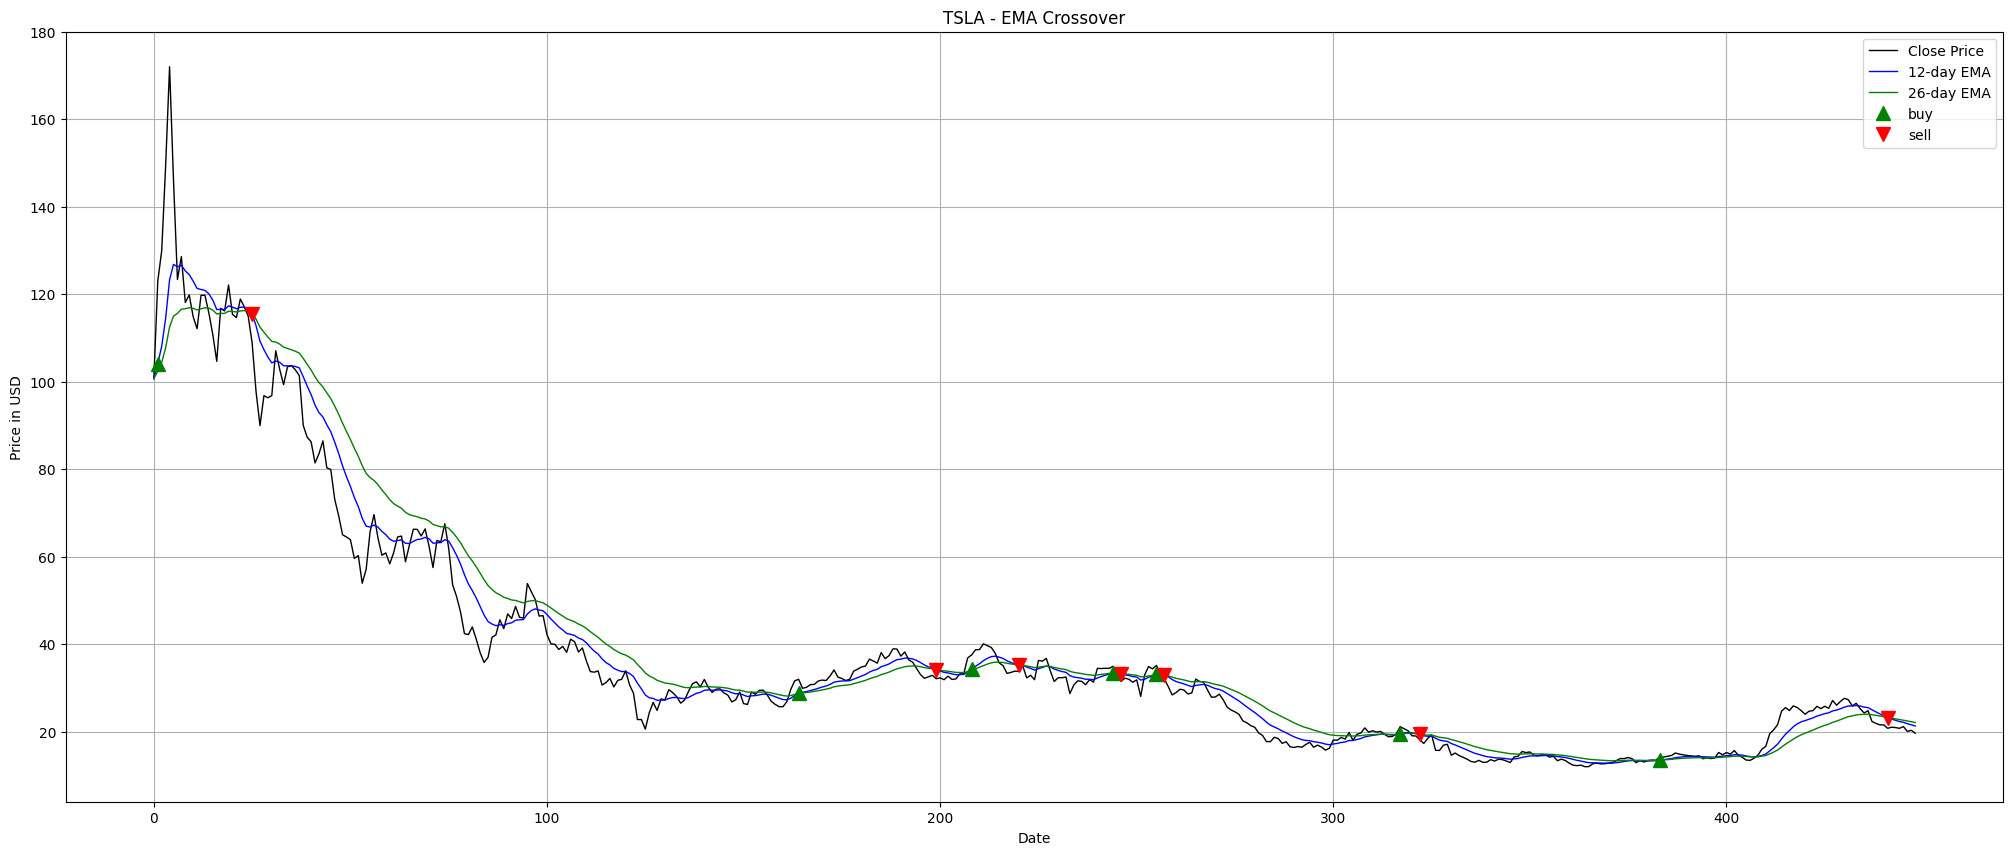

In [36]:
fig = plt.figure(figsize = (25,10))

TSLA['Close'].plot(color = 'k', lw = 1, label = 'Close Price')
TSLA['EMA_12'].plot(color = 'b', lw = 1, label = '12-day EMA')
TSLA['EMA_26'].plot(color = 'g', lw = 1, label = '26-day EMA')

plt.plot(TSLA[TSLA['EMA_Position'] == 1].index,
         TSLA['EMA_12'][TSLA['EMA_Position'] == 1],
         '^', markersize = 10, color = 'g', label = 'buy')

plt.plot(TSLA[TSLA['EMA_Position'] == -1].index,
         TSLA['EMA_12'][TSLA['EMA_Position'] == -1],
         'v', markersize = 10, color = 'r', label = 'sell')

plt.ylabel('Price in USD')
plt.xlabel('Date')
plt.title('TSLA - EMA Crossover')
plt.legend()
plt.grid()
plt.show()

fig.savefig('EMA_Crossover_Plot.png')

In [37]:
rmse = sqrt(mean_squared_error(TSLA['Close'], TSLA['EMA_12']))
rmse

5.086086456249066

In [38]:
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [39]:
x = TSLA['Close'].tolist()
y = TSLA['EMA_12'].tolist()

rsquared(x, y)

0.9690752202956042

In [40]:
for index, row in TSLA.iterrows():
    if TSLA.loc[index,'Close'] > TSLA.loc[index,'EMA_12']:
        TSLA.loc[index,'EMA_12_Signal'] = 1
    elif TSLA.loc[index,'Close'] < TSLA.loc[index,'EMA_12']:
        TSLA.loc[index,'EMA_12_Signal'] = -1
    else:
        TSLA.loc[index,'EMA_12_Signal'] = 0

In [41]:
TSLA.dropna(axis=0,how='any',inplace=True)
TSLA.head()

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_20,SMA_50,SMA_10,...,EMA_26,EMA_40,EMA_60,MACD,RSI,SMA_Signal,SMA_Position,EMA_Signal,EMA_Position,EMA_12_Signal
1,2021-11-11,114.625000,125.000000,108.010002,122.989998,122.989998,83668200,111.860001,111.860001,111.860001,...,102.378892,101.815857,101.459839,1.775726,100.00000,0.0,0.0,1.0,1.0,1.0
2,2021-11-12,128.645004,135.199997,125.250000,129.949997,129.949997,50636800,117.889999,117.889999,117.889999,...,104.421196,103.188254,102.393943,3.701942,100.00000,0.0,0.0,1.0,0.0,1.0
3,2021-11-15,130.800003,152.529999,127.510002,149.360001,149.360001,64982300,125.757500,125.757500,125.757500,...,107.749996,105.440534,103.933814,6.717274,100.00000,0.0,0.0,1.0,0.0,1.0
4,2021-11-16,163.800003,179.470001,153.779999,172.009995,172.009995,94036600,135.007999,135.007999,135.007999,...,112.509996,108.687825,106.165819,10.810001,100.00000,0.0,0.0,1.0,0.0,1.0
5,2021-11-17,160.880005,163.000000,140.350006,146.070007,146.070007,71765600,136.851667,136.851667,136.851667,...,114.995923,110.511346,107.474153,11.824076,69.77763,0.0,0.0,1.0,0.0,1.0


In [42]:
TSLA['EMA_12_Signal']= TSLA['EMA_12_Signal'].shift(1)
TSLA

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_20,SMA_50,SMA_10,...,EMA_26,EMA_40,EMA_60,MACD,RSI,SMA_Signal,SMA_Position,EMA_Signal,EMA_Position,EMA_12_Signal
1,2021-11-11,114.625000,125.000000,108.010002,122.989998,122.989998,83668200,111.860001,111.860001,111.860001,...,102.378892,101.815857,101.459839,1.775726,100.000000,0.0,0.0,1.0,1.0,NaN
2,2021-11-12,128.645004,135.199997,125.250000,129.949997,129.949997,50636800,117.889999,117.889999,117.889999,...,104.421196,103.188254,102.393943,3.701942,100.000000,0.0,0.0,1.0,0.0,1.0
3,2021-11-15,130.800003,152.529999,127.510002,149.360001,149.360001,64982300,125.757500,125.757500,125.757500,...,107.749996,105.440534,103.933814,6.717274,100.000000,0.0,0.0,1.0,0.0,1.0
4,2021-11-16,163.800003,179.470001,153.779999,172.009995,172.009995,94036600,135.007999,135.007999,135.007999,...,112.509996,108.687825,106.165819,10.810001,100.000000,0.0,0.0,1.0,0.0,1.0
5,2021-11-17,160.880005,163.000000,140.350006,146.070007,146.070007,71765600,136.851667,136.851667,136.851667,...,114.995923,110.511346,107.474153,11.824076,69.777630,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,2023-08-18,20.250000,21.170000,20.180000,20.780001,20.780001,25477700,24.196500,21.123400,22.002000,...,22.765296,22.043215,20.932438,-0.441120,39.013971,1.0,0.0,0.0,0.0,-1.0
445,2023-08-21,20.860001,21.320000,20.740000,21.180000,21.180000,21257500,23.965000,21.266000,21.692000,...,22.647867,22.001107,20.940555,-0.499718,41.642214,1.0,0.0,0.0,0.0,-1.0
446,2023-08-22,21.379999,21.469999,19.770000,20.080000,20.080000,30521700,23.701500,21.390200,21.220000,...,22.457654,21.907395,20.912340,-0.627682,36.928966,1.0,0.0,0.0,0.0,-1.0
447,2023-08-23,19.760000,20.490000,19.610001,20.320000,20.320000,17583100,23.360000,21.516600,21.017000,...,22.299310,21.829961,20.892919,-0.701641,38.562846,1.0,0.0,0.0,0.0,-1.0


In [43]:
TSLA['EMA_12_Signal'].value_counts()

EMA_12_Signal
-1.0    262
 1.0    185
Name: count, dtype: int64

In [44]:
initial_amt = 30000
total_shares = 30
initial_accountbalance = initial_amt
initial_shares = total_shares

print('Account balance ',initial_amt)
print('Initial number of shares owned ',total_shares)
ini_price = TSLA.loc[1,'Close']
avg_price = TSLA['Close'].mean()
initial_val = initial_amt + ini_price*total_shares
#initial amount+total_shares*ini_price

for index, row in TSLA.iterrows():
    if TSLA.loc[index,'EMA_12_Signal'] == 1:
        if (initial_amt - TSLA.loc[index,'Close'])> 0 :
            initial_amt -= TSLA.loc[index,'Close']
            avg_price = ((avg_price*total_shares)+TSLA.loc[index,'Close'])/(total_shares+1)
            total_shares = total_shares + 1;
            TSLA.loc[index,'Action'] = "Buy"
        else:
            TSLA.loc[index,'Action'] = "Buy Alert"
    elif TSLA.loc[index,'EMA_12_Signal'] == -1:
        if total_shares - 1 > 0 :
            TSLA.loc[index,'Action'] = "Sell"
            avg_price = ((avg_price*total_shares)-TSLA.loc[index,'Close'])/(total_shares-1)
            initial_amt += TSLA.loc[index,'Close'];
            total_shares = total_shares - 1;
        else:
            TSLA.loc[index,'Action'] = "Sell Alert"
    else:
        TSLA.loc[index,'Action'] = "Hold"

print('----------------Signals Given During Day To Day Trade------------------------')
print(TSLA.tail(10))
print('----------------Results-------------------------')
print('Balance left in Account',initial_amt)
print('Total Number of shares ',total_shares)
final_amt = initial_amt

Account balance  30000
Initial number of shares owned  30
----------------Signals Given During Day To Day Trade------------------------
          Date       Open       High        Low      Close  Adj Close  \
439 2023-08-11  21.980000  21.980000  21.280001  21.570000  21.570000   
440 2023-08-14  20.900000  21.799999  20.520000  21.559999  21.559999   
441 2023-08-15  21.660000  21.860001  20.450001  20.780001  20.780001   
442 2023-08-16  20.375000  21.450001  20.200001  21.040001  21.040001   
443 2023-08-17  21.059999  21.799999  20.660000  20.950001  20.950001   
444 2023-08-18  20.250000  21.170000  20.180000  20.780001  20.780001   
445 2023-08-21  20.860001  21.320000  20.740000  21.180000  21.180000   
446 2023-08-22  21.379999  21.469999  19.770000  20.080000  20.080000   
447 2023-08-23  19.760000  20.490000  19.610001  20.320000  20.320000   
448 2023-08-24  20.200001  20.264999  19.480000  19.639999  19.639999   

       Volume   SMA_20   SMA_50  SMA_10  ...     EMA_40     

In [45]:
# Profit calculation
inital_share_worth = initial_shares * TSLA.loc[min(TSLA.index),'Close'] + initial_accountbalance

final_shares = total_shares
final_share_worth = final_shares * TSLA.loc[max(TSLA.index),'Close'] + final_amt

profit_percent = (final_share_worth - inital_share_worth)/inital_share_worth
print('Profit gained: ', profit_percent*100, '%')

Profit gained:  -5.383559153193979 %


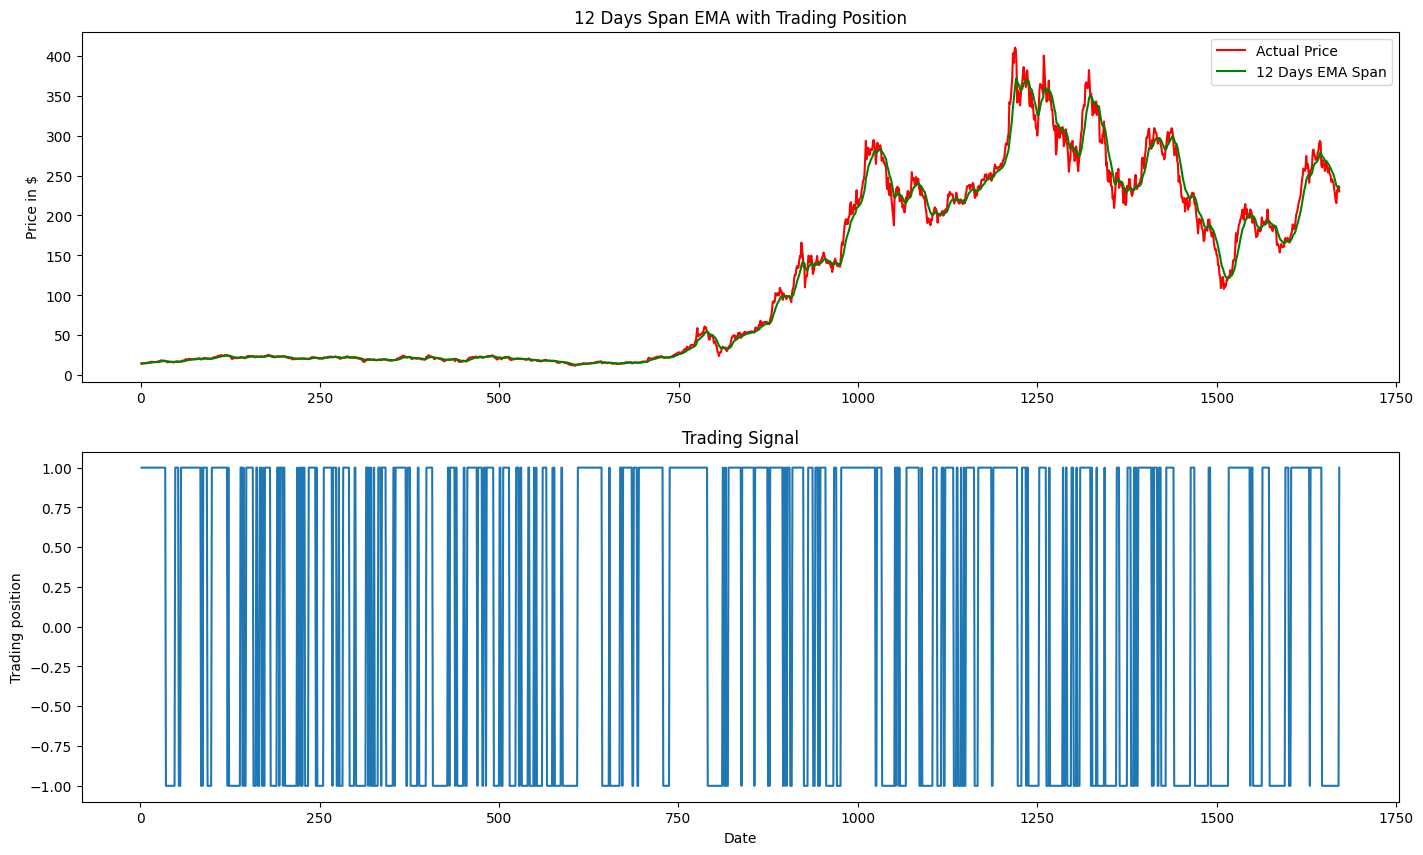

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17,10))

ax1.plot(TSLA['Close'], label='Actual Price', color = 'red')
ax1.plot(TSLA['EMA_12'], label = '12 Days EMA Span', color = 'green')
ax1.set_title('12 Days Span EMA with Trading Position')
ax1.set_ylabel('Price in $')
ax1.legend(loc='best')

ax2.plot(TSLA['EMA_12_Signal'], label='Trading position')
ax2.set_title('Trading Signal')
ax2.set_xlabel('Date')
ax2.set_ylabel('Trading position')

fig.savefig('Trading_Strategy.png')